<a href="https://colab.research.google.com/github/JyothiNandhan/Nandhan/blob/main/NANO_VLM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import math,random
import numpy as np

In [ ]:
import torch,torch.nn as nn, torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from PIL import Image, ImageDraw
import matplotlib.pyplot as plt

Variables


In [ ]:
device=torch.device('cuda' if torch.cuda.is_available() else 'cpu')
IMG_SIZE=32
EMBED_DIM=12
ATTENTION_HEADS=3
BATCH_SIZE=4
EPOCHS=10
LR=3e-4
TEMPERATURE=0.07

Synthetic dataset properties

In [ ]:
colors=['red','green','blue','yellow','purple','orange','pink','brown','gray']
shapes=['square','circle','triangle']
positions=['left','center','right','top','bottom','top-left','top-right','bottom-left','bottom-right']

<H3>Drawing Image Shapes</H3>

In [ ]:
def draw_sample(color, shape, position, image_size=IMG_SIZE):
  img=Image.new('RGB',(image_size,image_size),'white')
  draw=ImageDraw.Draw(img)

  margin=6
  h=w=image_size-2*margin
  if 'left' in position:
    x0=margin
    x1=margin+w//2
  elif 'top-left' in position:
    x0=margin
    x1=margin+w//2
  elif 'bottom-left' in position:
    x0=margin
    x1=margin+w//2
  elif 'right' in position:
    x0=margin+w//2
    x1=image_size-margin
  elif 'top-right' in position:
    x0=margin+w//2
    x1=image_size-margin
  elif 'bottom-right' in position:
    x0=margin+w//2
    x1=image_size-margin
  else:
    x0=margin+w//4
    x1=margin+3*w//4

  if 'top' in position:
    y0=margin
    y1=margin+h//2
  elif 'top-left' in position:
    y0=margin
    y1=margin+h//2
  elif 'top-right' in position:
    y0=margin
    y1=margin+h//2
  elif 'bottom' in position:
    y0=margin+h//2
    y1=image_size-margin
  elif 'bottom-left' in position:
    y0=margin+h//2
    y1=image_size-margin
  elif 'bottom-right' in position:
    y0=margin+h//2
    y1=image_size-margin
  else:
    y0=margin+h//4
    y1=margin+3*h//4

  if shape=='square':
    draw.rectangle([x0,y0,x1,y1],fill=color,outline='black')
  elif shape=='circle':
    draw.ellipse([x0,y0,x1,y1],fill=color,outline='black')
  else:
    draw.polygon([(x1+x0)//2,y0,(x0,y1),(x1,y1)],fill=color, outline='black')
  return img


##class for building the dataset


In [ ]:
class ShapesDataset():
  def __init__(self):
    self.images=[]
    self.captions=[]

    for c in colors:
      for s in shapes:
        for p in positions:
          img= draw_sample(c,s,p)
          cap =f"{c} {s} {p}"

          # Using / 255.0 ensures floating point precision for the neural network
          img_tensor = torch.from_numpy(np.asarray(img)).permute(2,0,1).float() / 255.0
          self.images.append(img_tensor)
          self.captions.append(cap)
    self.vocab,self.word2idx=self.build_vocab(self.captions)

  def build_vocab(self,texts):
    words=sorted({w for t in texts for w in t.split()})
    vocab=['[CLS]']+words
    w2i={w:i for i,w in enumerate(vocab)}
    return vocab, w2i
  def __len__(self):
    return len(self.images)

  def encode_text(self,text):
    toks=[self.word2idx['[CLS]']]+[self.word2idx[w] for w in text.split()]
    return torch.tensor(toks, dtype=torch.long)

  def __getitem__(self,idx):
     return self.images[idx], self.encode_text(self.captions[idx])

In [ ]:
full_ds=ShapesDataset()
VOCAB_SIZE=len(full_ds.vocab)
print(VOCAB_SIZE)

22


In [ ]:
print(full_ds.vocab)


['[CLS]', 'blue', 'bottom', 'bottom-left', 'bottom-right', 'brown', 'center', 'circle', 'gray', 'green', 'left', 'orange', 'pink', 'purple', 'red', 'right', 'square', 'top', 'top-left', 'top-right', 'triangle', 'yellow']


##Train-val Data creation



In [ ]:
train_size = int(0.8 * len(full_ds))
val_size = len(full_ds) - train_size
train_ds, val_ds = torch.utils.data.random_split(full_ds, [train_size, val_size])

print(len(train_ds),len(val_ds))

194 49


In [ ]:
train_loader=DataLoader(train_ds,batch_size=BATCH_SIZE, shuffle=True)
Val_loader=DataLoader(val_ds,batch_size=BATCH_SIZE,shuffle=False)


##Display a sampled data point


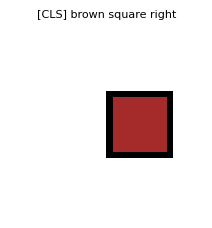

In [ ]:
images, encoded_caps = next(iter(train_loader))
idx = random.randint(0, len(images) - 1)
img = (images[idx].permute(1, 2, 0).numpy() * 255).astype(np.uint8)

plt.figure(figsize=(2.5, 2.5))
plt.imshow(img)
caption_text = " ".join([full_ds.vocab[i] for i in encoded_caps[idx]])
plt.title(caption_text, fontsize=8)
plt.axis('off')
plt.show()

##Image Encoder

In [ ]:
class ImageEncoder(nn.Module):
  def __init__(self,embed_dim=EMBED_DIM):
    super().__init__()
    self.convolutions= nn.Sequential(
        nn.Conv2d(3,32,3,2,1),
        nn.ReLU(),
        nn.Conv2d(32,64,3,2,1), # Fixed: changed 33 to 32
        nn.ReLU(),
        nn.Conv2d(64,128,3,2,1),
        nn.ReLU(),
        nn.Conv2d(128,256,3,2,1),
        nn.ReLU(),
    )
    self.projection= nn.Linear(256,embed_dim)
    self.layernorm1= nn.LayerNorm(embed_dim)

  def forward(self,x):
    x=self.convolutions(x)
    x=x.mean(dim=[2,3])
    x=self.projection(x)
    x=F.normalize(self.layernorm1(x),dim=-1)
    return x

##Text Encoder


In [ ]:
class TextEncoder(nn.Module):
  def __init__(self,embed_dim=EMBED_DIM,num_heads=ATTENTION_HEADS,vocab_size=VOCAB_SIZE,context_window=4):
    super().__init__()
    self.token_embedding=nn.Embedding(vocab_size, embed_dim)
    self.position_embedding=nn.Embedding(context_window, embed_dim)
    self.mha=nn.MultiheadAttention(embed_dim,num_heads,batch_first=True)
    self.projection=nn.Linear(embed_dim,embed_dim)
    self.norm=nn.LayerNorm(embed_dim)

  # def forward(self,toks):
  #   N,L=toks.shape
  #   position_emb_ids=torch.arange(L,device=toks.device).unsqueeze(0).expand(N,L)
  #   position_embedding_vectors=self.position_embedding(position_emb_ids)
  #   token_embedding_ids= toks
  #   token_embedding_vectors= self.token_embedding(token_embedding_ids)
  #   final_embedding=token_embedding_vectors+ position_embedding_vectors
  #   context_vectors=self.mha(final_embedding,final_embedding,final_embedding)[0]
  #   final_token= context_vectors[:,0]
  #   projection=self.projection(final_token)
  #   output=F.normalize(self.norm(projection),dim=-1)
  #   return output

  def forward(self,toks):
    N,L=toks.shape
    position_emb_ids=torch.arange(L,device=toks.device).unsqueeze(0).expand(N,L)
    position_embedding_vectors=self.position_embedding(position_emb_ids)
    token_embedding_vectors= self.token_embedding(toks)
    final_embedding=token_embedding_vectors+ position_embedding_vectors
    context_vectors=self.mha(final_embedding,final_embedding,final_embedding)[0]
    final_token= context_vectors[:,0]
    projection=self.projection(final_token)
    output=F.normalize(self.norm(projection),dim=-1)
    return output



In [ ]:
def clip_loss(img_emb,txt_emb, temperature=TEMPERATURE):
  logits=img_emb @ txt_emb.T/ temperature
  targets= torch.arange(img_emb.size(0),device=img_emb.device) # Fixed typo: arrange -> arange
  loss_i = F.cross_entropy(logits,targets)
  loss_t=F.cross_entropy(logits.T, targets)
  return((loss_i+loss_t)/2.0)

##Model,data,optimizer



In [ ]:
img_enc=ImageEncoder().to(device)
text_enc=TextEncoder().to(device)
params=list(img_enc.parameters())+list(text_enc.parameters())
optimizer=torch.optim.AdamW(params,lr=LR)

In [ ]:
def show_image(t,title=None):
  img=(t.permute(1,2,0).numpy() * 255).astype(np.uint8)
  plt.figure(figsize=(2.2,2.2))
  plt.axis('off')
  if title: plt.title(title)
  plt.imshow(img)
  plt.show()

Sample image and caption for embeddings visualization: 'yellow circle bottom-right'


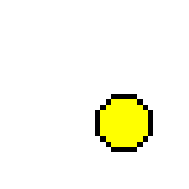

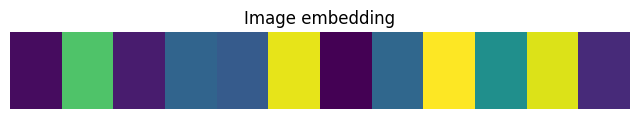

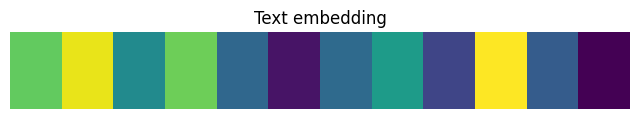

In [ ]:
img_enc.eval()
text_enc.eval()

with torch.no_grad():
  # Fixed typo: random_idxx -> random_idx
  random_idx = random.randrange(len(full_ds))
  sample_img, sample_toks = full_ds[random_idx]
  sample_cap = full_ds.captions[random_idx]

  sample_img_input = sample_img.unsqueeze(0).to(device)
  sample_toks_input = sample_toks.unsqueeze(0).to(device)

  # Pass the required 'toks' argument to text_enc
  pre_train_img_emb = img_enc(sample_img_input).squeeze(0).cpu().numpy()
  pre_train_txt_emb = text_enc(sample_toks_input).squeeze(0).cpu().numpy()

  print(f"Sample image and caption for embeddings visualization: '{sample_cap}'")
  show_image(sample_img.cpu())

  def plot_embedding(embedding, title):
    plt.figure(figsize=(8,1))
    plt.imshow(embedding.reshape(1,-1), aspect='auto', cmap='viridis')
    plt.title(title)
    plt.axis('off')
    plt.show()

  plot_embedding(pre_train_img_emb, 'Image embedding')
  plot_embedding(pre_train_txt_emb, 'Text embedding')

##Training Loop


In [ ]:
# Training Loop
print(f"Training on {device}...")

for epoch in range(EPOCHS):
    img_enc.train()
    text_enc.train()
    train_loss = 0

    for imgs, caps in train_loader:
        imgs = imgs.to(device)
        caps = caps.to(device)

        optimizer.zero_grad()

        img_emb = img_enc(imgs)
        txt_emb = text_enc(caps)

        loss = clip_loss(img_emb, txt_emb)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()

    # Validation
    img_enc.eval()
    text_enc.eval()
    val_loss = 0
    with torch.no_grad():
        for imgs, caps in Val_loader:
            imgs = imgs.to(device)
            caps = caps.to(device)

            img_emb = img_enc(imgs)
            txt_emb = text_enc(caps)
            loss = clip_loss(img_emb, txt_emb)
            val_loss += loss.item()

    print(f"Epoch [{epoch+1}/{EPOCHS}] | Train Loss: {train_loss/len(train_loader):.4f} | Val Loss: {val_loss/len(Val_loader):.4f}")

Training on cuda...
Epoch [1/10] | Train Loss: 1.4520 | Val Loss: 1.1649
Epoch [2/10] | Train Loss: 1.1503 | Val Loss: 0.9557
Epoch [3/10] | Train Loss: 0.7961 | Val Loss: 0.8978
Epoch [4/10] | Train Loss: 0.5004 | Val Loss: 0.6679
Epoch [5/10] | Train Loss: 0.3352 | Val Loss: 0.3004
Epoch [6/10] | Train Loss: 0.2099 | Val Loss: 0.2282
Epoch [7/10] | Train Loss: 0.1632 | Val Loss: 0.1422
Epoch [8/10] | Train Loss: 0.1196 | Val Loss: 0.1066
Epoch [9/10] | Train Loss: 0.1257 | Val Loss: 0.1110
Epoch [10/10] | Train Loss: 0.1470 | Val Loss: 0.1390


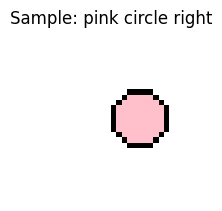

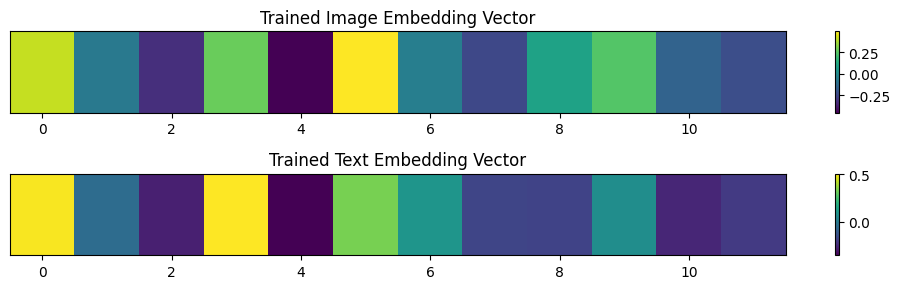


Image Embedding (first 5): [ 0.4089741  -0.06904375 -0.32465643  0.27547345 -0.45066187]
Text Embedding (first 5):  [ 0.49638572 -0.04895823 -0.27683273  0.50384784 -0.35345632]


In [ ]:
def visualize_results_with_embeddings(num_samples=1):
    global img_emb, txt_emb
    img_enc.eval()
    text_enc.eval()

    for _ in range(num_samples):
        # Select random sample from validation set
        idx = random.randrange(len(val_ds))
        img_tensor, tokens = val_ds[idx]
        caption = " ".join([full_ds.vocab[t] for t in tokens if full_ds.vocab[t] != '[CLS]'])

        with torch.no_grad():
            # Added .cpu() before .numpy() to fix CUDA conversion error
            img_emb = img_enc(img_tensor.unsqueeze(0).to(device)).cpu().numpy()
            txt_emb = text_enc(tokens.unsqueeze(0).to(device)).cpu().numpy()

        # 1. Show the Image
        show_image(img_tensor.cpu(), title=f"Sample: {caption}")

        # 2. Plot Embeddings as heatmaps
        fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 3))

        im1 = ax1.imshow(img_emb, aspect='auto', cmap='viridis')
        ax1.set_title('Trained Image Embedding Vector')
        ax1.set_yticks([])
        plt.colorbar(im1, ax=ax1)

        im2 = ax2.imshow(txt_emb, aspect='auto', cmap='viridis')
        ax2.set_title('Trained Text Embedding Vector')
        ax2.set_yticks([])
        plt.colorbar(im2, ax=ax2)

        plt.tight_layout()
        plt.show()

        # Print first few numerical values
        print(f"\nImage Embedding (first 5): {img_emb[0][:5]}")
        print(f"Text Embedding (first 5):  {txt_emb[0][:5]}")

visualize_results_with_embeddings()

In [ ]:
# Re-calculate or use existing embeddings from the last visualization run
# Note: img_emb and txt_emb were created in cell d0e55d6a

print("\nDot product between image and text embeddings:")
# pre_train vectors are already numpy arrays from cell hLO7hc4kbO1D
print(f"Before training: {np.dot(pre_train_img_emb, pre_train_txt_emb):.4f}")

# Ensure we use the 1D versions of the embeddings for the dot product
# img_emb and txt_emb from visualize_results_with_embeddings are shape (1, 64)
print(f"After training: {np.dot(img_emb[0], txt_emb[0]):.4f}")


Dot product between image and text embeddings:
Before training: -0.1588
After training: 0.8800


Query: 'blue square center'
Similarity Score: 0.8245


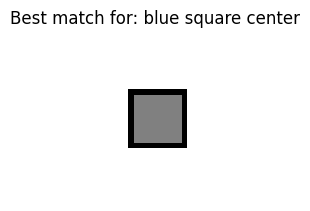

In [ ]:
def text_to_image_retrieval(query_text):
    img_enc.eval()
    text_enc.eval()

    try:
        # 1. Encode the input text
        tokens = full_ds.encode_text(query_text).unsqueeze(0).to(device)
        with torch.no_grad():
            query_emb = text_enc(tokens) # [1, Embed_Dim]

        # 2. Get embeddings for all images in the validation set
        val_images = torch.stack([val_ds[i][0] for i in range(len(val_ds))]).to(device)
        with torch.no_grad():
            val_img_embs = img_enc(val_images) # [Val_Size, Embed_Dim]

        # 3. Calculate cosine similarity (dot product since vectors are normalized)
        scores = (query_emb @ val_img_embs.T).squeeze(0)
        best_idx = scores.argmax().item()

        # 4. Display the result
        print(f"Query: '{query_text}'")
        print(f"Similarity Score: {scores[best_idx].item():.4f}")
        show_image(val_ds[best_idx][0].cpu(), title=f"Best match for: {query_text}")

    except KeyError:
        print(f"Error: One of the words in '{query_text}' is not in the vocabulary.")

# Example usage:
# Corrected 'triangle' to 'traingle' to match vocabulary
test_caption = "blue square center"
text_to_image_retrieval(test_caption)